In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
import geopandas as gpd
import fiona
import networkx as nx


/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [77]:
# Sample bounding boxes (From Google Maps Geocoding API)
bboxes = {
    'london': [51.38494,-0.351468,51.672343,0.148271],
    'birmingham': [52.385999,-2.017434,52.568876,-1.709829],
    'liverpool': [53.320448,-3.019179,53.503907,-2.812938],
    'manchester': [53.399903,-2.300097,53.544588,-2.146829],
    'leeds': [53.730803,-1.674091,53.881202,-1.397373],
    'sheffield': [53.304551,-1.663959,53.486883,-1.334953],
    'bristol': [51.392545,-2.730533,51.544433,-2.450902],
    'leicester': [52.58065,-1.215988,52.691504,-1.046213],
    'nottingham': [52.889,-1.24829,53.019045,-1.091834],
    'coventry': [52.363911,-1.605885,52.463472,-1.423951],
    'oxford': [51.704532,-1.319999,51.796301,-1.175176],
    'cambridge': [52.159829,0.048047,52.237855,0.191927],
    'south': [50.743408,-2.639465,52.830151,0.821228]
}
training_place = 'coventry'
test_places = ['oxford', 'liverpool']

# Projection
from pyproj import CRS, Transformer
crs_proj = CRS.from_epsg(27700)
crs_4326 = CRS("WGS84")
transformer = Transformer.from_crs(crs_4326, crs_proj)

def proj_and_reorder_bounds(bbox):
  S, W, N, E = bbox
  [S, N], [W, E] = transformer.transform([S, N], [W, E])
  return (S, W, N, E)


       metres meridian_class  choice2km  choice2kmrank  choice2kmlog  \
0  165.196852          minor      766.0       0.279345      2.884795   
1  297.001683          minor     4694.5       0.617274      3.671682   
2  168.585290          minor      617.0       0.223715      2.790988   
3  249.569630          minor      609.0       0.220490      2.785330   
4  264.007576          minor     1883.5       0.393258      3.275196   
5  258.652276          minor    11596.0       0.807263      4.064346   
6   59.211485          minor     1179.5       0.466742      3.072066   
7   58.137767          minor      149.5       0.149083      2.177536   
8  186.000000          minor      476.0       0.264557      2.678518   
9  123.199026          minor     5011.5       0.761084      3.700054   

   nodecount2km  integration2km  integration2kmrank    choice10km  \
0         377.0       92.748433            0.320291  1.741383e+04   
1         363.0      107.654234            0.387480  9.263400e+04   


<AxesSubplot:>

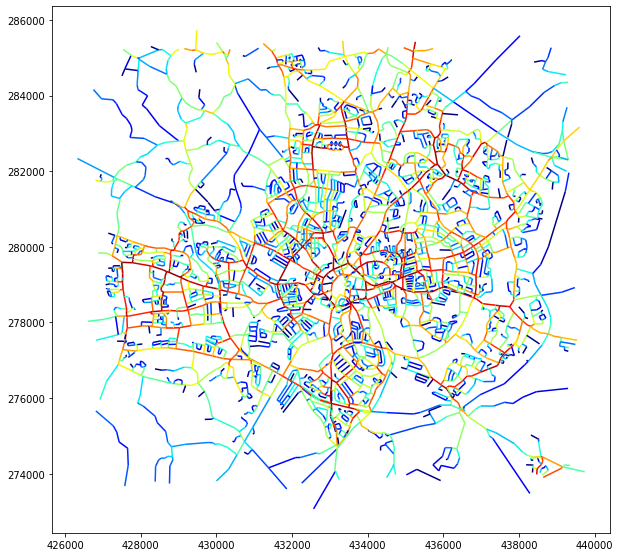

In [3]:
# Load dataset
meridian_fields = ['meridian_id', 'meridian_gid', 'meridian_code',
                   'meridian_osodr', 'meridian_number', 'meridian_road_name',
                   'meridian_indicator', 'meridian_class_scale']
census_geom_fields = ['oa11cd', 'wz11cd', 'lsoa11cd', 'lsoa11nm', 'msoa11cd', 'msoa11nm',
                      'lad11cd', 'lad11nm']
misc_fields = ['id']
ignore_fields = meridian_fields + census_geom_fields + misc_fields
radius = '2km'
modifier = 'rank'
geoms = 5

loaded_gdfs = {}
def load_gdf(place=training_place, verbose=False): #(W, S, E, N)
  if place in loaded_gdfs:
    return loaded_gdfs[place]
  if place == 'nobounds':
        gdf = gpd.read_file('./OpenMapping-gb-v1_gpkg/gpkg/ssx_openmapping_gb_v1.gpkg',
                            ignore_fields=ignore_fields)
  else:
        bounds = proj_and_reorder_bounds(bboxes[place])
        gdf = gpd.read_file('./OpenMapping-gb-v1_gpkg/gpkg/ssx_openmapping_gb_v1.gpkg',
                              bbox=bounds, ignore_fields=ignore_fields)
  if verbose:
      print(f'{gdf.size} geometries retrieved from {place}')
  loaded_gdfs[place] = gdf
  return gdf

from fiona.errors import DriverError
try:
  gdf = load_gdf()
except DriverError:
  # Download GeoPackage from Space Syntax
  !wget https://github.com/spacesyntax/OpenMapping/releases/download/gb-v1/ssx_OpenMapping_gb_v1_gpkg.zip
  !unzip ssx_OpenMapping_gb_v1_gpkg.zip
  gdf = load_gdf()

print(gdf.head(10))
print(gdf.dtypes)
f, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, column=f'choice{radius}{modifier}', cmap='jet')

# Data preprocessing

In [4]:
# Graph Feature Processing
import momepy
from matplotlib import cm, colors
from shapely.geometry import LineString
from sklearn.preprocessing import OneHotEncoder

def centroid_generation(g):
    pos = {}
    for e, d in g.nodes(data=True):
        mid = d['geometry'].centroid
        pos[e] = {'midpoint': np.array([mid.x, mid.y])}
    nx.set_node_attributes(g, pos)
    pass

def centroid_subtraction(g):
    for _, d in g.nodes(data=True):
        d['geom'] = d['geom'] - d['midpoint']
    pass

def generate_geometries(g, attr_name='geom', steps=geoms, verbose=False):
    if verbose:
        print(f'Generating fixed length {steps} geometry vectors...')
    geoms = nx.get_node_attributes(g, 'geometry')
    np_same_length_geoms = {}
    count_no = 0
    count_yes = 0
    for e in g.nodes():
        points = []

        if e not in geoms:  # edges that don't have a geometry
            raise ValueError('Why?')
            line = LineString([(xs[e[0]], ys[e[0]]), (xs[e[1]], ys[e[1]])])
            for step in np.linspace(0, 1, steps):
                point = line.interpolate(step, normalized=True)
                points.append([point.x, point.y])
            count_no += 1

        else:  # all other edges
            for step in np.linspace(0, 1, steps):
                point = geoms[e].interpolate(step, normalized=True)
                points.append([point.x, point.y])
            count_yes += 1
        np_same_length_geoms[e] = np.array([np.array((p[0], p[1])) for p in points])

    if verbose > 0:
        print('- Geometry inserted from intersection coordinates for', count_no, 'nodes.')
        print('- Standardized geometry created for', count_no + count_yes, 'nodes.')

    nx.set_node_attributes(g, np_same_length_geoms, attr_name)
    if verbose > 0:
        print('Done.')
    pass

def one_hot_encode_meridian_class(g):
    labels_standard = set()
    labels = nx.get_node_attributes(g, 'meridian_class')
    labels_int = {}
    
    for edge in g.nodes():
        label = labels[edge]
        labels_int[edge] = label
        labels_standard.add(label)

    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(np.array(list(labels_standard)).reshape(-1, 1))

    print('- One-hot encoder fitted to data with following categories:')
    print('-', np.array(enc.categories_).flatten().tolist())

    labels_one_hot = {k: enc.transform(np.array(v).reshape(1, -1)).toarray().flatten().tolist() for k, v in
                         labels_int.items()}

    nx.set_node_attributes(g, labels_one_hot, 'class_one_hot')
    pass

# Not resorting to this for now
# def bin_and_one_hot_encode_target(g, num_classes, rad='2km', mod=''):
#     _, target_attr = get_attrs(rad, mod)
#     target_attrs = nx.get_node_attributes(g, target_attr).values()
#     hist = np.histogram(target_attrs, bins=num_classes)

#     for 

def set_graph_features(g, rad=radius, mod=modifier):
    node_attrs, target_attr = get_attrs(rad, mod)

    # delete unused features
    for _, d in g.nodes(data=True):
        feats = {} # temporary dict
        feats['metres'] = d['metres']
        feats['mid_x'] = d['midpoint'][0]
        feats['mid_y'] = d['midpoint'][1]
        for i, point in enumerate(d['geom']):
            feats[f'geom{i}_x'] = point[0]
            feats[f'geom{i}_y'] = point[1]
        feats['y'] = d[target_attr]
        for attr in node_attrs:
            if attr not in feats:
                # get feature from node data
                feats[attr] = d[attr]

        d.clear()
        for k in feats:
            d[k] = feats[k]
    pass

def process_graph(g, rad=radius, mod=modifier, num_geom=geoms, verbose=False):
    # geometry labelling
    # one_hot_encode_meridian_class(g)
    generate_geometries(g, steps=num_geom, verbose=verbose)
    centroid_generation(g)
    centroid_subtraction(g)
    set_graph_features(g, rad, mod)

    return g

# TODO: Extract out num_geoms
def get_attrs(rad=radius, mod=modifier, num_geom=geoms):
    curr_attrs = [f'nodecount{rad}', f'integration{rad}{mod}']
    attr_dict = {
        '2km': ['log', 'rank'],
        '10km': ['log', 'rank'],
        '100km': ['log']
    }
    mods = attr_dict[rad]
    if mod not in mods + ['']:
      raise KeyError(f'Invalid modifier {mod} for radius {rad}')
    target_attr = f'choice{rad}{mod}'
    base_attrs = ['metres', 'mid_x', 'mid_y'] + \
     [g for i in range(num_geom) for g in (f'geom{i}_x', f'geom{i}_y')]
    node_attrs = base_attrs + curr_attrs
    
    return node_attrs, target_attr

# Done before process_graph
def print_target_distribution(g, rad=radius, mod=modifier):
    _, target_attr = get_attrs(rad=rad, mod=mod)
    labels = nx.get_node_attributes(g, target_attr)
    targets = list(labels.values())
    plt.title(f'{target_attr} histogram')
    _ = plt.hist(targets, bins='auto')
    plt.show()

# Data Loading

In [67]:
# General use dataloader
from itertools import chain
from torch_geometric.utils.convert import from_networkx

loaded_graphs={}

def load_graph(place=training_place, rad=radius, mod=modifier, num_geom=geoms,
               num_val=0, batch_size=32, num_neighbors=[], num_parts=1, verbose=False):
  key = (place, rad, mod, num_geom)
  if key in loaded_graphs:
    g = loaded_graphs[key]
    if verbose:
        print('Loaded existing graph.')
  else:
    gdf = load_gdf(place)
    G = momepy.gdf_to_nx(gdf, approach='dual')
    if verbose:
      print(f'Generated graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')
      print_target_distribution(G, rad=rad, mod=mod)
    
    G_processed = process_graph(G, rad=rad, mod=mod, num_geom=num_geom, verbose=verbose)
    if verbose:
        # List node and edge attributes
        node_attrs = set(chain.from_iterable(d.keys() for *_, d in G_processed.nodes(data=True)))
        edge_attrs = set(chain.from_iterable(d.keys() for *_, d in G_processed.edges(data=True)))
        print(f'Node attributes: {node_attrs}, Edge Attributes: {edge_attrs}')

    node_attrs, _ = get_attrs(rad, mod)
    g = from_networkx(G_processed, group_node_attrs=node_attrs,
                      group_edge_attrs=['angle'])
    loaded_graphs[key] = g
  
  if num_val > 0:
    # Assign train_mask and val_mask to data
    from torch_geometric.transforms import RandomNodeSplit
    g = RandomNodeSplit(num_val=num_val, num_test=0)(g)
    
    if len(num_neighbors) > 0:
        # Return NeighborLoader
        from torch_geometric.loader import NeighborLoader
        return g, NeighborLoader(g, num_neighbors=num_neighbors, batch_size=batch_size,
                                 input_nodes=g.train_mask, shuffle=True)
      
  if num_parts > 1:
    # Return ClusterLoader
    from torch_geometric.loader import ClusterData, ClusterLoader
    cluster_data = ClusterData(g, num_parts=num_parts)
    return g, ClusterLoader(cluster_data, batch_size=batch_size, shuffle=True)
  else:
    # Return normal DataLoader
    from torch_geometric.loader import DataLoader
    return g, DataLoader([g], batch_size=batch_size, shuffle=True)


# Models

In [45]:
from torch_geometric.nn import Linear, GCNConv, GATConv, SAGEConv
from torch.nn import ReLU, Sigmoid, Tanh, Sequential, ModuleList

activations = {
    'relu': ReLU,
    'sigmoid': Sigmoid,
    'tanh': Tanh
}


class LR(torch.nn.Module):
    def __init__(self, in_feats, num_classes):
        super(LR, self).__init__()
        self.linear = Linear(in_feats, num_classes)
        self.linear.reset_parameters()

    def forward(self, x, graph):
        return self.linear(x)


class MLP(torch.nn.Module):
    def __init__(self, in_feats, h_feats, num_layers, num_classes, act=None):
        super(MLP, self).__init__()
        assert num_layers >= 1
        channel_list = [h_feats] * (num_layers - 1)
        channel_list = [in_feats] + channel_list + [num_classes]
        
        layers = []
        for dims in zip(channel_list[:-1], channel_list[1:]):
            layers.append(Linear(*dims))
            layers.append(ReLU())
        if act:
            layers.append(activations[act]())
        self.layer = Sequential(*layers)

    def forward(self, x, _):
        out = self.layer(x)
        return out


class GNN(torch.nn.Module):
    def __init__(self, in_feats, h_feats, num_layers, num_classes):
        super(GNN, self).__init__()
        assert num_layers >= 1
        layer = self.get_layer()
        
        self.num_layers = num_layers
        self.layers = ModuleList()
        channel_list = [h_feats] * (num_layers - 1)
        channel_list = [in_feats] + channel_list + [num_classes]
        for dims in zip(channel_list[:-1], channel_list[1:]):
            self.layers.append(layer(*dims))

    def forward(self, data):
        # data should have the following 3 attributes
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # convert to float32
        x = x.float()

        x = self.layers[0](x, edge_index, edge_attr)
        for i in range(1, self.num_layers):
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
            x = self.layers[i](x, edge_index, edge_attr)

        return x
    
    def get_layer(self):
        # Override with respective conv layer
        raise NotImplementedError

        
class GCN(GNN):
    def __init__(self, in_feats, h_feats, num_layers, num_classes):
        super(GCN, self).__init__(in_feats, h_feats, num_layers, num_classes)

    def get_layer(self):
        return GCNConv


class GAT(GNN):
    def __init__(self, in_feats, h_feats, num_layers, num_classes):
        super(GAT, self).__init__(in_feats, h_feats, num_layers, num_classes)

    def get_layer(self):
        return GATConv

    
class SAGE(GNN):
    def __init__(self, in_feats, h_feats, num_layers, num_classes):
        super(SAGE, self).__init__(in_feats, h_feats, num_layers, num_classes)

    def get_layer(self):
        return SAGEConv
   

In [7]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Training loop

In [78]:
from sklearn.metrics import r2_score
from torch_geometric.data import Batch

USE_GPU = True
dtype = torch.float32 


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

def train(model, loader, optimizer, criterion):
    model.train()
    for data in loader:  # Iterate over each mini-batch.
        data = data.to(device)
        out = model(data).squeeze(1)  # Perform a single forward pass.
        loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(trained_model, loader, r2=False, masked=False):
    trained_model.eval()
    
    if r2:
      loader = loader.to(device)
      # Treat loader as Data object
      pred = trained_model(loader).cpu()
      loader = loader.cpu()
      if masked:
        return [r2_score(loader.y[mask].detach(), pred[mask].detach()) for mask in
                [loader.train_mask, loader.val_mask]]
      else:
        return r2_score(loader.y.detach(), pred.detach())

    # Calculate MAE
    error = [0, 0] if masked else 0
    num_samples = [0, 0]
    for data in loader:
      data = data.to(device)
      pred = trained_model(data).squeeze(1)
      if masked:
        for i, mask in enumerate([data.train_mask, data.val_mask]):
            error[i] += (pred[mask] - data.y[mask]).abs().sum().item()
            num_samples[i] += len(pred[mask])
      else:
        error += (pred - data.y).abs().sum().item()

    if masked:
      return error[0] / num_samples[0], error[1] / num_samples[1]
    else:
      return error / len(loader.dataset)

def run_tests(model, places=test_places, **kwargs):
    graphs = []
    for place in places:
        g, _ = load_graph(place, **kwargs)
        graphs.append(g)
        r2 = test(model, g, r2=True)
        print(f'R2 for {place}: {r2}')
    batch = Batch(graphs)
    r2 = test(model, batch, r2=True)
    print(f'Batched test R2: {r2}')

cuda:0


In [66]:
# Load data
geoms=5
g, loader = load_graph(num_val=0.2, num_geom=5, batch_size=128, verbose=True)

Loading existing graph...


In [79]:
# # from torch_geometric.nn import GCN, GAT, GraphSAGE
# num_feats = g.num_node_features
# num_classes = 1
# hidden_channels = 1024
# num_layers = 2
# model = GCN(num_feats, hidden_channels, num_layers, num_classes)
# # model = MLP(num_feats, hidden_channels, num_layers, num_classes, act='sigmoid')
# # model = LR(num_feats, num_classes)

# model = model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, cooldown=2, min_lr=1e-6, verbose=True)
# criterion = torch.nn.L1Loss()

# train_losses = []
# val_losses = []
# early_stop = False
# early_stopping = EarlyStopping(patience=100, verbose=False)
# epochs = 100000
# print_every = 100
# for epoch in range(1, epochs + 1):
#     loss = train(model, loader, optimizer, criterion)
#     train_loss, val_loss = test(model, loader, masked=True)
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     # scheduler.step(val_loss)
#     if (epoch) % print_every == 0:
#         start = len(train_losses) - print_every
#         mean_train = np.mean(train_losses[start:])
#         mean_val = np.mean(val_losses[start:])
#         print(f'Epoch: {epoch:03d}, Train: {mean_train:.4f}, Val: {mean_val:.4f}')
#     # early_stopping(val_loss, model)
#     # if early_stopping.early_stop and early_stop:
#     #     print("Early stopping")
#     #     break

r2s = test(model, g, masked=True, r2=True)
print(f'Training R2 {r2s[0]}')
print(f'Validation R2 {r2s[1]}')
run_tests(model, batch_size=128)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.yscale('log')
plt.legend()
plt.show()

Training R2 0.3625455334526435
Validation R2 0.36217001702578977
R2 for oxford: -9775807.316626702
R2 for liverpool: -245792362.83311537


RuntimeError: CUDA out of memory. Tried to allocate 11.69 GiB (GPU 0; 7.93 GiB total capacity; 3.01 GiB already allocated; 3.71 GiB free; 3.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Visualize model predictions

In [ ]:
# def add_preds_to_attrs(primal_graph, dual_graph, model):
#    graph = graph.to(device)
#    pred = trained_model(loader.x.float(), loader.edge_index)
   
#    pred_dict = {}
#    for e in primal_graph.edges():
#         points = []
#         if e not in geoms:  # edges that don't have a geometry
#             line = LineString([(xs[e[0]], ys[e[0]]), (xs[e[1]], ys[e[1]])])
#             for step in np.linspace(0, 1, steps):
#                 point = line.interpolate(step, normalized=True)
#                 points.append([point.x, point.y])
#             count_no += 1

#         else:  # all other edges
#             for step in np.linspace(0, 1, steps):
#                 point = geoms[e].interpolate(step, normalized=True)
#                 points.append([point.x, point.y])
#             count_yes += 1
#         pred_dict[e] = np.array([np.array((p[0], p[1])) for p in points])
#    nx.set_edge_attributes(primal_graph, pred_dict)

def visualize_preds(place, model, rad=radius, mod=modifier):
  loader, _ = load_graph(place, rad=rad, mod=mod)
  gdf = load_gdf(place)
  streets = momepy.gdf_to_nx(gdf, approach='dual')
  
  # Convert nx graph to dgl (preserves node order) and get model predictions 
  loader = loader.to(device)
  preds = model(loader.x.float(), loader.edge_index)
  
  # Assign prediction to nx attribute
  pred_dict = {}
  for i, e in enumerate(streets.nodes()):
    pred_dict[e] = preds[i].item()
  nx.set_node_attributes(streets, pred_dict, 'preds')

  # Convert nx graph back to gdf and plot actual and predicted values
  lines = momepy.nx_to_gdf(streets)
  f, ax = plt.subplots(1, 2, figsize=(30, 15), sharex=True, sharey=True)
  for i, facet in enumerate(ax):
      facet.set_title(("Actual", "Predicted")[i], fontweight="bold", size=16)
      facet.axis("off")
  lines.plot(ax=ax[0], column=f'choice{rad}{mod}', cmap='jet')
  lines.plot(ax=ax[1], column='preds', cmap='jet')

visualize_preds('london', model)


# Documentation...


In [ ]:
print(f'Training loss ({training_place}): {test(model, g_split, r2=True)}')
for place in bboxes:
  if place is not training_place:
    print(f'Testing {place}')
    test_graph, _ = load_graph(place, mod='', verbose=True)
    print(f'Loss: {test(model, test_graph, r2=True)}')